In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math


def plot_images(images, nrows=1, ncols=5, cmap='gray', figsize=(20, 10), filename=None):
    """
    Plot a list of images using matplotlib subplots.

    Args:
        images (list or np.ndarray): List or array of images to plot.
        nrows (int): Number of rows in the subplot grid.
        ncols (int): Number of columns in the subplot grid.
        cmap (str): Color map for the images (e.g., 'gray', 'viridis').
        figsize (tuple): Tuple specifying the overall figure size (width, height).
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Iterate through all the subplots
    for i, ax in enumerate(axes):
        if i < len(images):  # Plot if there are images left
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axes
        else:  # Turn off any extra axes (used when images < nrows*ncols)
            ax.axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


def show_reconstructions_code(model, images, shape, n_images=5, **kwargs):
    code = model.layers[0].predict(images[:n_images])
    code_images = code.reshape([n_images] + list(shape))
    reconstructed_images = model.layers[1].predict(code)
    # all_images = np.append(images, reconstructed_images, axis=0)
    all_images = [x for x in images[:n_images]]
    all_images.extend(code_images)
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=3, **kwargs)


def show_code_reconstructions(decoder, codes, n_images=5, shape=None):
    code_shape = (1, codes.shape[1])
    reconstructions = decoder.predict(codes[:n_images])
    reconstructed_images = reconstructions if shape is None else reconstructions.reshape([n_images] + list(shape))
    all_images = [x.reshape(code_shape) for x in codes]
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=2)


def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

2025-04-25 09:02:16.930248: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 09:02:16.932922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 09:02:16.983866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 09:02:16.984651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
mkdir -p failed for path /.config/matplotlib: [Errno 13] Permission denied: '/.config'
Matplotlib crea

4422102/4422102 [==============================] - 0s 0us/step


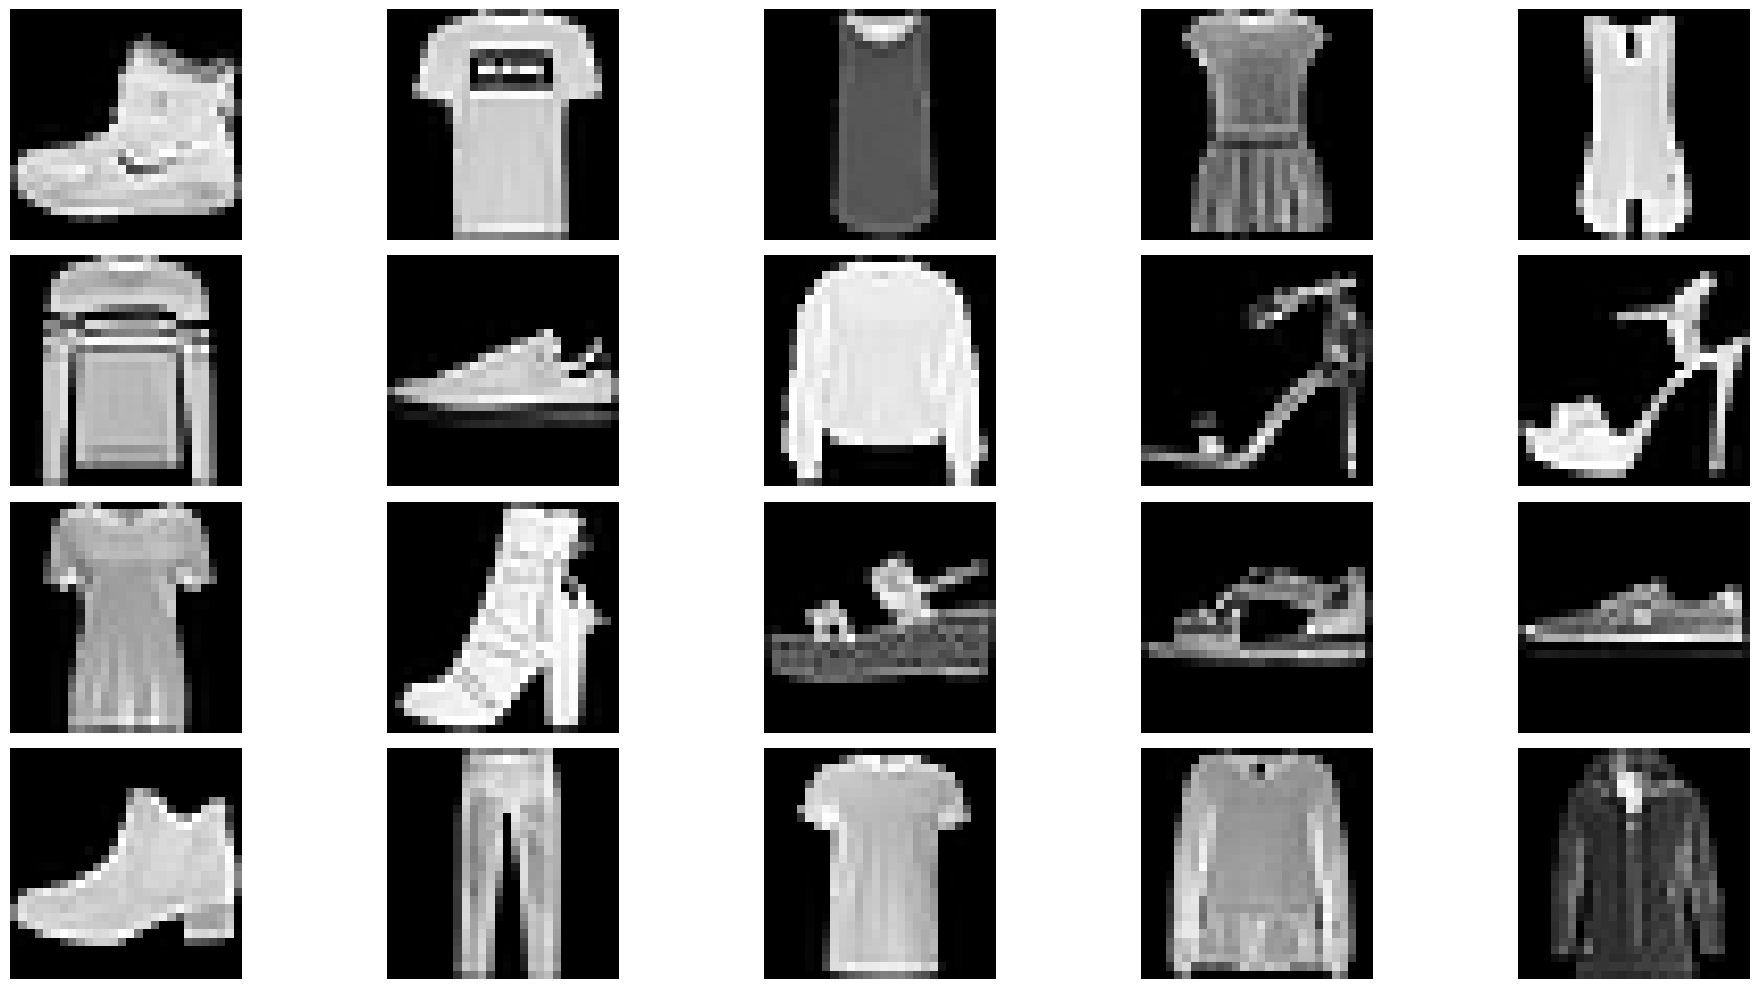

In [4]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

plot_images(X_train[:20], 4, 5)

In [5]:
base_model = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
base_model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    #optimizer="adam"
    metrics=["accuracy"]
)
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


2025-04-25 09:02:23.984997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-25 09:02:24.015235: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
base_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 1s - loss: 0.8347 - accuracy: 0.7845 - val_loss: 0.6492 - val_accuracy: 0.8194 - 1s/epoch - 782us/step
Epoch 2/10
1719/1719 - 1s - loss: 0.8261 - accuracy: 0.8107 - val_loss: 0.8383 - val_accuracy: 0.8166 - 1s/epoch - 608us/step
Epoch 3/10
1719/1719 - 1s - loss: 0.8469 - accuracy: 0.8119 - val_loss: 0.8015 - val_accuracy: 0.8226 - 956ms/epoch - 556us/step
Epoch 4/10
1719/1719 - 1s - loss: 0.8125 - accuracy: 0.8203 - val_loss: 0.7004 - val_accuracy: 0.8378 - 919ms/epoch - 534us/step
Epoch 5/10
1719/1719 - 1s - loss: 0.7932 - accuracy: 0.8223 - val_loss: 0.6861 - val_accuracy: 0.8402 - 924ms/epoch - 537us/step
Epoch 6/10
1719/1719 - 1s - loss: 0.8195 - accuracy: 0.8203 - val_loss: 0.9757 - val_accuracy: 0.7956 - 921ms/epoch - 536us/step
Epoch 7/10
1719/1719 - 1s - loss: 0.8249 - accuracy: 0.8230 - val_loss: 0.7821 - val_accuracy: 0.8296 - 932ms/epoch - 542us/step
Epoch 8/10
1719/1719 - 1s - loss: 0.8103 - accuracy: 0.8235 - val_loss: 0.7361 - val_accuracy: 0.8510 -

In [7]:
base_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 496us/step - loss: 0.9793 - accuracy: 0.7963


[0.979259192943573, 0.7962999939918518]

In [9]:
model1 = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(5, activation="relu", name="hidden_layer"),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model1.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=optimizer,
    # optimizer="adam",
    metrics=["accuracy"]
)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 5)                 3925      
                                                                 
 output_layer (Dense)        (None, 10)                60        
                                                                 
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [10]:
model1.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

Epoch 1/10
1719/1719 - 1s - loss: 0.9496 - accuracy: 0.6364 - val_loss: 0.7450 - val_accuracy: 0.7362 - 1s/epoch - 866us/step
Epoch 2/10
1719/1719 - 1s - loss: 0.7279 - accuracy: 0.7282 - val_loss: 0.6994 - val_accuracy: 0.7438 - 1s/epoch - 585us/step
Epoch 3/10
1719/1719 - 1s - loss: 0.7060 - accuracy: 0.7379 - val_loss: 0.6943 - val_accuracy: 0.7324 - 1s/epoch - 585us/step
Epoch 4/10
1719/1719 - 1s - loss: 0.6825 - accuracy: 0.7461 - val_loss: 0.7005 - val_accuracy: 0.7334 - 1s/epoch - 588us/step
Epoch 5/10
1719/1719 - 1s - loss: 0.6861 - accuracy: 0.7450 - val_loss: 0.7168 - val_accuracy: 0.7250 - 1s/epoch - 635us/step
Epoch 6/10
1719/1719 - 1s - loss: 0.6743 - accuracy: 0.7499 - val_loss: 0.6747 - val_accuracy: 0.7546 - 1s/epoch - 598us/step
Epoch 7/10
1719/1719 - 1s - loss: 0.6820 - accuracy: 0.7469 - val_loss: 0.7395 - val_accuracy: 0.7474 - 1s/epoch - 666us/step
Epoch 8/10
1719/1719 - 1s - loss: 0.6774 - accuracy: 0.7501 - val_loss: 0.6646 - val_accuracy: 0.7532 - 1s/epoch - 586

In [11]:
model2 = keras.Sequential(
    [
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="selu", name="hidden_layer"),
        keras.layers.Dense(10, activation="softmax", name="output_layer"),
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.02)
model2.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        # optimizer="adam",
        metrics=["accuracy"]
        )
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 hidden_layer (Dense)        (None, 64)                50240     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2, batch_size=32)

Epoch 1/10
